In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import schedule
import time
import gc
from sqlalchemy import exc
from sklearn.svm import SVR
from pandas.plotting import scatter_matrix
from pandas import DataFrame
from datetime import datetime
from sqlalchemy import create_engine
%matplotlib inline

In [2]:
def etl():
    #Connect to MySQL
    engine_db = create_engine('mysql://root:@localhost/bitcoin1')
    engine_warehouse = create_engine('mysql://root:@localhost/bitwar')

    ####Extracting####
    #read CSV file
    df_raw = pd.read_csv("raw.csv")

    check = engine_db.has_table("raw_csv")
    if check == False:
        for i in range(3):
            try:
                
                with engine_db.connect() as conn, conn.begin():
                    df_raw.to_sql('raw_csv', conn, if_exists='append', index = False)
            except exc.DBAPIError:
                continue
            else:
                break
        else:
             print("Connection invalidated")

    #read existing data from db
    query = "select * from raw_csv"
    df_db = pd.read_sql_query(query,engine_db)

    #find new data if new csv or datasource provided
    df_diff = pd.concat([df_raw,df_db]).drop_duplicates(keep=False)    
    for i in range(3):
        try:  
            #Insert new data to DB
            with engine_db.connect() as conn, conn.begin():
                df_diff.to_sql('raw_csv', conn, if_exists='append', index = False)
        
        except exc.DBAPIError:
            continue
        else:
            break
    else:
        print("Connection invalidated")
    
    #####Transform####
    df_db_trans = pd.read_sql_query(query,engine_db)
    df_db_trans = df_db_trans.fillna(0) 

    #converting Timestamp to date and time
    df_db_trans['Timestamp'] = pd.to_datetime(df_db_trans.Timestamp, unit = 's')

    df_db_trans = df_db_trans.set_index('Timestamp')

    df_month = df_db_trans.resample('M').mean()
    df_month = df_month.dropna()

    df_year = df_db_trans.resample('Y').mean()
    df_year = df_year.dropna()

    df_daily = df_db_trans.resample('D').mean()
    df_daily = df_daily.dropna()

    ###LOADING###
    #Insert transformed data to warehouse
    with engine_warehouse.connect() as conn, conn.begin():
        df_month.to_sql('monthly', conn, if_exists='append', index = True)
        df_year.to_sql('yearly', conn, if_exists='append', index = True)
        df_daily.to_sql('daily', conn, if_exists='append', index = True)
    


    ###collecting data from warehouse for analysis
    monthly_query = "select * from monthly"
    yearly_query = "select * from yearly"
    daily_query = "select * from daily"

    df_monthly_from_warehouse =  pd.read_sql_query(monthly_query,engine_warehouse)
    df_yearly_from_warehouse =  pd.read_sql_query(yearly_query,engine_warehouse)
    df_daily_from_warehouse =  pd.read_sql_query(daily_query,engine_warehouse)
    
    #Report generating
    
    df1 = df_monthly_from_warehouse.set_index(df_monthly_from_warehouse['Timestamp'])
    df2 = df_yearly_from_warehouse.set_index(df_yearly_from_warehouse['Timestamp'])
    df3 = df_daily_from_warehouse.set_index(df_daily_from_warehouse['Timestamp'])
    
    #Monthly Volume_currency VS Timestamp
    df1.plot(x = 'Timestamp', y = 'Volume_(Currency)')
    plt.title('Monthly_Volume_(Currency)vs Time')
    plt.savefig('monthly.pdf')
    plt.close()
    
    #yearly Volume_currency VS Timestamp
    df2.plot(x = 'Timestamp', y = 'Volume_(Currency)')
    plt.title('yearly_Volume_(Currency)vs Time')
    plt.savefig('yearly.pdf')
    plt.close()
    
    #daily Volume_currency VS Timestamp
    df3.plot(x = 'Timestamp', y = 'Volume_(Currency)')
    plt.title('daily_Volume_(Currency)vs Time')
    plt.savefig('daily.pdf')
    plt.close()
    
    gc.collect()
    
    print("done")



done


In [3]:
def job():
    etl()
    
schedule.every(1).minutes.do(job)
while True:
    schedule.run_pending()
    time.sleep(1)
    

In [14]:
###Prediction##
df1 = df_monthly_from_warehouse.set_index(df_monthly_from_warehouse['Timestamp'])
df2 = df_yearly_from_warehouse.set_index(df_yearly_from_warehouse['Timestamp'])
df3 = df_daily_from_warehouse.set_index(df_daily_from_warehouse['Timestamp'])


In [11]:
import statsmodels.formula.api as sm

In [12]:
##OLS regression is done, by knowing the coef. we can predict Y


#Regression prediction on Volume_BTC yearly data
df2.reset_index(drop=True, inplace=True)
#Regression prediction on Volume_BTC yearly data
data_Volume_BTC_yearly = pd.DataFrame({'Y': df2['Volume_(BTC)'],'X1': df2['Close'],'X2': df2['Low'],
                                       'X3': df2['Weighted_Price'],'X4': df2['Open']})

result = sm.ols(formula= "Y ~ X1 + X2 + X3 + X4", data = data_Volume_BTC_yearly ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1.839
Date:                Thu, 21 Nov 2019   Prob (F-statistic):              0.136
Time:                        19:33:56   Log-Likelihood:                -142.91
No. Observations:                  54   AIC:                             295.8
Df Residuals:                      49   BIC:                             305.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8225      0.643      9.061      0.000       4.531       7.114
X1          -126.4291    116.026     -1.090      0.281    -359.592     106.734
X2            -9.8976      8.363     -1.184      0.242     -26.703       6.908
X3            74.2818     66.969      1.109      0.273     -60.298     208.862
X4            62.0398     75.218      0.825      0.413     -89.117     213.196
==============================================================================
Omnibus:                        3.923   Durbin-Watson:                   1.138
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                2.106
Skew:                          -0.210   Prob(JB):                        0.349
Kurtosis:                       2.128   Cond. No.                     2.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [13]:
#Regression prediction on Volume_Currency yearly data
data_Volume_Currency_yearly = pd.DataFrame({'Y': df2['Volume_(Currency)'],'X1': df2['Close'],'X2': df2['Low'],
                                       'X3': df2['Weighted_Price'],'X4': df2['Open']})

result = sm.ols(formula= "Y ~ X1 + X2 + X3 + X4", data = data_Volume_BTC_yearly ).fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      Y   R-squared:                       0.131
Model:                            OLS   Adj. R-squared:                  0.060
Method:                 Least Squares   F-statistic:                     1.839
Date:                Thu, 21 Nov 2019   Prob (F-statistic):              0.136
Time:                        19:56:43   Log-Likelihood:                -142.91
No. Observations:                  54   AIC:                             295.8
Df Residuals:                      49   BIC:                             305.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.8225      0.643      9.061      0.000       4.531       7.114
X1          -126.4291    116.026     -1.090      0.281    -359.592     106.734
X2            -9.8976      8.363     -1.184      0.242     -26.703       6.908
X3            74.2818     66.969      1.109      0.273     -60.298     208.862
X4            62.0398     75.218      0.825      0.413     -89.117     213.196
==============================================================================
Omnibus:                        3.923   Durbin-Watson:                   1.138
Prob(Omnibus):                  0.141   Jarque-Bera (JB):                2.106
Skew:                          -0.210   Prob(JB):                        0.349
Kurtosis:                       2.128   Cond. No.                     2.06e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.06e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [29]:
#resampled daily data by hour
df_h = df3

df_h["Open"] = df_h.Open.resample("1H",how = "first")
df_h["High"] = df_h.High.resample("1H",how = "max")
df_h["Low"] = df_h.Low.resample("1H",how = "min")
df_h["Close"] = df_h.Close.resample("1H",how = "last")
df_h['Volume_(BTC)'] = df_h['Volume_(BTC)'].resample("1H",how = "sum")
df_h['Volume_(Currency)'] = df_h['Volume_(Currency)'].resample("1H",how = "sum")
df_h["Weighted_Price"] = df_h['Volume_(Currency)'] / df_h['Volume_(BTC)']

df_h.Weighted_Price.plot()
plt.title('hourly weighted data')
plt.savefig('hourly.pdf')
plt.close()




C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).first()
  after removing the cwd from sys.path.
C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).max()
  """
C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).min()
  
C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).last()
  import sys
C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  
C:\Users\Hasan\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...).sum()
  

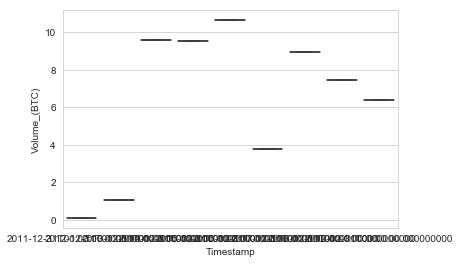

In [41]:
####Anomaly (outlies) detection with boxplot
df_anomaly = df2
sns.set_style("whitegrid")
sns.boxplot(x='Timestamp', y='Volume_(BTC)', data = df2)
